# ENSAE Master Spécialisé Data Science - Projet Python de 1er semestre

*Par Alexandre Combessie et Thibaut Duguet*

## Chargement des données

Les données complètes sont disponibles sur le site http://jmcauley.ucsd.edu/data/amazon/links.html. Pour commencer, on se concentre sur des bases de données pour des catégories spécifiques de produit, afin d'avoir une taille raisonnable.

In [1]:
import os
import json
import gzip
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
from IPython.display import display
import statistics as stat
from io import StringIO
import nltk
import sklearn

Tout d'abord, on sélectionne la catégorie de produit à étudier:

In [2]:
category_options={
    "Musical Instruments": "reviews_Musical_Instruments.json.gz",
    "Baby": "reviews_Baby.json.gz",
    "Movies and TV": "reviews_Movies_and_TV.json.gz",
}
dropdown = widgets.Dropdown(options=category_options, description="Catégorie de produit à étudier")
display(dropdown)

Ensuite, on décompresse le fichier pour obtenir un fichier en format json

In [ ]:
if(not(os.path.isfile(dropdown.value[:-3]))):
    inputFile = gzip.open(dropdown.value, 'rb')
    outputFile = open(dropdown.value[:-3], 'wb')
    outputFile.write(inputFile.read())
    inputFile.close()
    outputFile.close()

On la transforme en Pandas DataFrame 

In [ ]:
data=[]
filepath=dropdown.value[:-3]
with open(filepath) as f:
    for line in f:
        data.append(json.loads(line))
df=pd.DataFrame(data)

In [ ]:
df.to_csv("Movies and TV.csv", sep='\t')

In [3]:
df=pd.read_csv("Movies and TV.csv", sep='\t')

In [4]:
print(df.shape)
df.head()

(4607088, 10)


,Unnamed: 0,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,0,0000143502,"[0, 0]",5,This has some great tips as always and is help...,"01 17, 2013",A3R5OBKS7OM2IR,Rebecca L. Johnson,Alton... nough said,1358380800
1,1,0000143529,"[0, 0]",5,This is a great pastry guide. I love how Alto...,"10 2, 2013",A3R5OBKS7OM2IR,Rebecca L. Johnson,Ah Alton...,1380672000
2,2,0000143561,"[2, 4]",2,I have to admit that I am a fan of Giada's coo...,"07 17, 2008",AH3QC2PC1VTGP,Great Home Cook,Don't waste your money,1216252800
3,3,0000143588,"[9, 9]",5,I bought these two volumes new and spent over ...,"03 13, 2009",A3LKP6WPMP9UKX,Anna V. Carroll,VOLUME 1 & VOLUME 2-BETTER THAN THERAPY,1236902400
4,4,0000143588,"[1, 4]",5,I am very pleased with the dvd only wish i cou...,"01 18, 2009",AVIY68KEPQ5ZD,Rebecca Millington,Barefoot Contesst Vol 2,1232236800


## Séparation Training and Validation sets

Avant de commencer toute analyse ou modélisation, il faut séparer l'échantillon d'entrainement et l'échantillon de validation. On procède comme suit:

In [4]:
from sklearn.cross_validation import train_test_split
y = df["overall"]
X = df.drop("overall",axis=1,inplace=False)
X_train,X_test,y_train,y_test = train_test_split(X.index,y,test_size=0.2)
df_train=pd.concat([X,y],axis=1).iloc[X_train] # return dataframe train
df_test=pd.concat([X,y],axis=1).iloc[X_test] # return dataframe test
print(df_train.shape, df_test.shape)

(3685670, 10) (921418, 10)


In [5]:
del df

In [6]:
del X, y

In [7]:
del X_train, X_test

## Analyse descriptive

Regardons la structure de la table:

In [9]:
df_train.head()

,Unnamed: 0,asin,helpful,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime,overall
2733833,2733833,B000VXWK8Q,"[1, 1]","i love this, this brings back memorys its wort...","07 18, 2013",A37U0U3OTXWY7N,nick retherford,good product,1374105600,5
3089918,3089918,B001OQ17SI,"[0, 0]","Given this really is for Steelers fans, having...","05 13, 2009",A17L2COJUQLTM3,Jason Brynford-Jones,Having only brief highlights was a disappointment,1242172800,3
907509,907509,6304117752,"[0, 0]","After 183 Amazon.com reviews, these few though...","03 17, 2001",A2J0U1XP6JPL9L,"Charles W. Adams ""Charles W. Adams""",Julie Andrews/Rodgers &amp; Hammerstein classi...,984787200,5
465383,465383,6300182355,"[0, 0]","Definently worth the money and wait, completel...","08 17, 2013",A3LXKXHQDTH4Q1,Jason Harris,Flash Gordon Movie,1376697600,5
3879830,3879830,B005LAIHZY,"[1, 1]",Very fun for the whole family. No crude humor...,"12 27, 2012",A6RHOAE7AN48D,Mandy,Cute movie,1356566400,5


In [10]:
del df_train["reviewerName"], df_test["reviewerName"]

Etudions les dimensions clés de la table:

In [11]:
Nbreviews=len(df_train)
Nbproducts=len(set(df_train["asin"]))
Nbreviewers=len(set(df_train["reviewerID"]))
print("Le nombre total de reviews est: "+str(Nbreviews))
print("Le nombre total de produits est: "+str(Nbproducts))
print("Le nombre total de reviewers est: "+str(Nbreviewers))
print("Soit un nombre moyen de "+str(round(Nbreviews/Nbproducts,1))+ " reviews par produit")
print("Soit un nombre moyen de "+str(round(Nbreviews/Nbreviewers,1))+ " reviews par reviewers")

Le nombre total de reviews est: 3685670
Le nombre total de produits est: 187873
Le nombre total de reviewers est: 1781889
Soit un nombre moyen de 19.6 reviews par produit
Soit un nombre moyen de 2.1 reviews par reviewers


Analysons la distribution des notes des reviews

count    3685670.00
mean           4.19
std            1.23
min            1.00
25%            4.00
50%            5.00
75%            5.00
max            5.00
Name: overall, dtype: float64


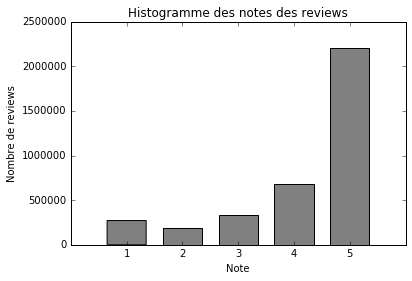

In [12]:
print(df_train["overall"].describe().round(2))
%matplotlib inline 
a=[int(i) for i in df_train["overall"]]
bins=range(1,7)
fig, ax = plt.subplots(1,1)
ax.hist(a, bins=bins, align='left', color="grey", rwidth=0.7)
ax.set_xticks(bins[:-1])
plt.title("Histogramme des notes des reviews");
plt.xlabel("Note");
plt.ylabel("Nombre de reviews");

Regardons la distribution des notes moyennes par produit. On constate que la distribution est moins "skewed" que précedemment.

count    187873.00
mean          4.02
std           1.01
min           1.00
25%           3.50
50%           4.25
75%           5.00
max           5.00
Name: overall, dtype: float64


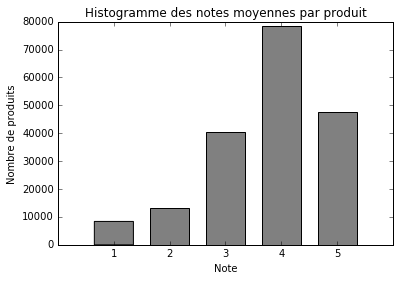

In [13]:
average_note_byproduct=df_train[["asin","overall"]].groupby("asin", as_index=False).mean()
print(average_note_byproduct["overall"].describe().round(2))
%matplotlib inline 
bins=range(1,7)
fig, ax = plt.subplots(1,1)
ax.hist(average_note_byproduct["overall"], bins=bins, align='left', color="grey", rwidth=0.7)
ax.set_xticks(bins[:-1])
plt.title("Histogramme des notes moyennes par produit");
plt.xlabel("Note");
plt.ylabel("Nombre de produits");

Regardons la distribution du nombre de reviews par utilisateur.

count    1781889.00
mean           2.07
std            9.83
min            1.00
25%            1.00
50%            1.00
75%            2.00
max         2115.00
dtype: float64


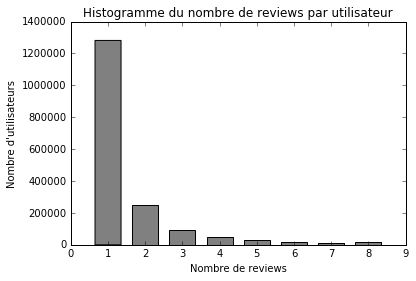

In [14]:
import collections
Nbreview_by_user=collections.Counter(df_train["reviewerID"])
print(pd.Series(Nbreview_by_user).describe().round(2))
bins=range(1,10,1)
a = np.clip(list(Nbreview_by_user.values()), 1, 10)
fig, ax = plt.subplots(1,1)
ax.hist(a, bins=bins, align='left', color="grey", rwidth=0.7)
plt.title("Histogramme du nombre de reviews par utilisateur");
plt.xlabel("Nombre de reviews");
plt.ylabel("Nombre d'utilisateurs");

Définissons la fonction de comptage du nombre de mots d'une review et appliquons la à nos données

In [8]:
def countWords(review):
    return(len(review.split()))

In [9]:
df_train["countWordsReview"] = df_train["reviewText"].astype(str).apply(countWords)
df_test["countWordsReview"] = df_test["reviewText"].astype(str).apply(countWords)
df_train["countWordsSummary"] = df_train["summary"].astype(str).apply(countWords)
df_test["countWordsSummary"] = df_test["summary"].astype(str).apply(countWords)

Regardons la distribution du nombre de mots des reviews

In [17]:
print(df_train["countWordsReview"].describe().round(2))

count    3685670.00
mean         108.44
std          157.45
min            1.00
25%           27.00
50%           51.00
75%          122.00
max         5925.00
Name: countWordsReview, dtype: float64


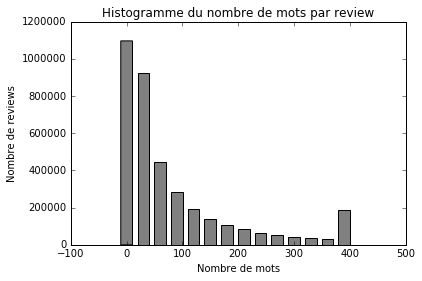

In [25]:
%matplotlib inline 
bins=range(0,430,30)
a = list(np.clip(df_train["countWordsReview"], 0, 400))
fig, ax = plt.subplots(1,1)
ax.hist(a, bins=bins, align='left', color="grey", rwidth=0.7)
plt.title("Histogramme du nombre de mots par review");
plt.xlabel("Nombre de mots");
plt.ylabel("Nombre de reviews");

Maintenant regardons plus spécifiquement entre 0 et 100 mots

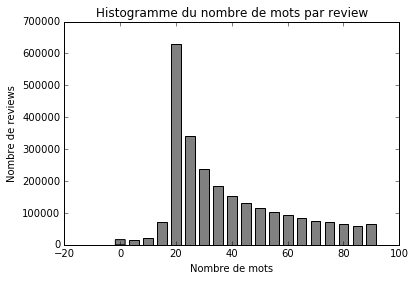

In [20]:
a = [s for s in df_train["countWordsReview"] if s < 101]
%matplotlib inline 
bins=range(0,100,5)
fig, ax = plt.subplots(1,1)
ax.hist(a, bins=bins, align='left', color="grey", rwidth=0.7)
plt.title("Histogramme du nombre de mots par review");
plt.xlabel("Nombre de mots");
plt.ylabel("Nombre de reviews");

## Préparation des données

On prépare les données de texte en utilisant la fonction `TfidfVectorizer` du package `sklearn`. Notons que nous utilisons les stopwords donnés par `nltk` pour réduire le nombre de mots.

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
tfidf_vect = TfidfVectorizer()
tfidf_vect_stopword = TfidfVectorizer(stop_words= stopwords.words('english'), min_df=0.001)

### 1. Texte complet de la review

#### a. Echantillon Train

In [12]:
corpus_train_reviewText=list(df_train["reviewText"].astype(str))
X_train_tfidf_reviewText = tfidf_vect_stopword.fit_transform(corpus_train_reviewText)
X_train_tfidf_reviewText.shape

(3685670, 5663)

In [13]:
del df_train["reviewText"]

#### b. Echantillon Test

In [14]:
corpus_test_reviewText=list(df_test["reviewText"].astype(str))
X_test_tfidf_reviewText = tfidf_vect_stopword.transform(corpus_test_reviewText)
X_test_tfidf_reviewText.shape

(921418, 5663)

In [15]:
del df_test["reviewText"]

### 2. Texte du résumé de la review

#### a. Echantillon Train

In [16]:
corpus_train_summary=list(df_train["summary"].astype(str))
X_train_tfidf_summary = tfidf_vect_stopword.fit_transform(corpus_train_summary)
X_train_tfidf_summary.shape

(3685670, 396)

In [17]:
del df_train["summary"]

#### b. Echantillon Test

In [18]:
corpus_test_summary=list(df_test["summary"].astype(str))
X_test_tfidf_summary = tfidf_vect_stopword.transform(corpus_test_summary)
X_test_tfidf_summary.shape

(921418, 396)

In [19]:
del df_test["summary"]

### 3. Features supplémentaires

Nous allons créer des variables pour le mois et le jour de la review, ce qui peut influencer la note.

In [20]:
from datetime import datetime
df_train["Weekday"] = df_train["unixReviewTime"].apply(lambda x: datetime.strftime(datetime.fromtimestamp(x),'%a')).astype('category')
df_test["Weekday"] = df_test["unixReviewTime"].apply(lambda x: datetime.strftime(datetime.fromtimestamp(x),'%a')).astype('category')
df_train["Weekday"].head()

1544338    Thu
3367318    Tue
37434      Wed
2907236    Thu
854364     Fri
Name: Weekday, dtype: category
Categories (7, object): [Fri, Mon, Sat, Sun, Thu, Tue, Wed]

In [21]:
df_train["Month"] = df_train["unixReviewTime"].apply(lambda x: datetime.strftime(datetime.fromtimestamp(x),'%m')).astype('category')
df_test["Month"] = df_test["unixReviewTime"].apply(lambda x: datetime.strftime(datetime.fromtimestamp(x),'%m')).astype('category')
df_train["Month"].head()

1544338    08
3367318    08
37434      02
2907236    10
854364     05
Name: Month, dtype: category
Categories (12, object): [01, 02, 03, 04, ..., 09, 10, 11, 12]

In [22]:
from sklearn.feature_extraction import DictVectorizer
dic_vec = DictVectorizer()

#### a. Echantillon Train

In [23]:
from sklearn.preprocessing import normalize
X_train_countWords=normalize(df_train[["countWordsReview","countWordsSummary"]].astype(float),axis=0)
print(X_train_countWords.shape)

(3685670, 2)


In [24]:
dic_train_weekdays = pd.DataFrame(df_train["Weekday"]).to_dict('records')
X_train_weekdays = dic_vec.fit_transform(dic_train_weekdays)
X_train_weekdays.shape

(3685670, 7)

In [25]:
dic_train_months = pd.DataFrame(df_train["Month"]).to_dict('records')
X_train_months = dic_vec.fit_transform(dic_train_months)
X_train_months.shape

(3685670, 12)

#### b. Echantillon Test

In [26]:
from sklearn.preprocessing import normalize
X_test_countWords=normalize(df_test[["countWordsReview","countWordsSummary"]].astype(float),axis=0)
print(X_test_countWords.shape)

(921418, 2)


In [27]:
dic_test_weekdays = pd.DataFrame(df_test["Weekday"]).to_dict('records')
X_test_weekdays = dic_vec.fit_transform(dic_test_weekdays)
X_test_weekdays.shape

(921418, 7)

In [28]:
dic_test_months = pd.DataFrame(df_test["Month"]).to_dict('records')
X_test_months = dic_vec.fit_transform(dic_test_months)
X_test_months.shape

(921418, 12)

In [29]:
del df_train["unixReviewTime"], df_test["unixReviewTime"], df_train["Month"], df_test["Month"], df_train["Weekday"], df_test["Weekday"]

In [30]:
del df_train["reviewTime"], df_test["reviewTime"], df_train["helpful"], df_test["helpful"]

### 4. Combinaison de toutes les features

#### a. Echantillon Train

In [31]:
from scipy.sparse import hstack
X_train_alltext=hstack([X_train_tfidf_reviewText, X_train_tfidf_summary])
print(X_train_alltext.shape)

(3685670, 6059)


In [32]:
X_train_allfeatures = hstack([X_train_alltext,X_train_countWords, X_train_weekdays, X_train_months])
print(X_train_allfeatures.shape)

(3685670, 6080)


In [33]:
X_train_supfeatures = hstack([X_train_countWords, X_train_weekdays, X_train_months])
print(X_train_supfeatures.shape)

(3685670, 21)


#### b. Echantillon Test

In [34]:
X_test_alltext=hstack([X_test_tfidf_reviewText, X_test_tfidf_summary])
print(X_test_alltext.shape)

(921418, 6059)


In [35]:
X_test_allfeatures = hstack([X_test_alltext,X_test_countWords, X_test_weekdays, X_test_months])
print(X_test_allfeatures.shape)

(921418, 6080)


In [36]:
X_test_supfeatures = hstack([X_test_countWords, X_test_weekdays, X_test_months])
print(X_test_supfeatures.shape)

(921418, 21)


## Machine Learning

En utilisant la librairie `sklearn`, nous allons appliquer les modèles suivants:
- Naive Bayes avec modèle multinomial, 
- Support Vector Machines avec Stochastic Gradient Descent et fonction de perte logistique, 
- k-Nearest Neighbors. 

Nous avons essayé des Random Forests mais les calculs n'ont jamais pu aboutir, compte tenu du grand nombre de dimensions. Nous avons choisi un modèle Multinomial pour le Naive Bayes car il est bien adapté aux données (matrice sparse de grande dimension). Un modèle Naive Bayes gaussian n'est pas compatible avec les matrices sparses, et un modèle Naive Bayes Bernoulli ne peut prendre que des variables booléennes en entrée. Quant au choix de la fonction de perte logistique pour le modèle Support Vector Machines, c'est la seule fonction qui permet de calculer des probabilités sur les valeurs prédites et donc de déterminer le critère AUC.

### 1. Texte complet de la review

In [37]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(X_train_tfidf_reviewText, y_train.astype('category'))
predicted_NaiveBayes_reviewText = clf.predict(X_test_tfidf_reviewText)

In [38]:
from sklearn.linear_model import SGDClassifier
SGDclass = SGDClassifier(loss='log', penalty='l2', alpha=1e-3, n_iter=5, random_state=42)
clf2 = SGDclass.fit(X_train_tfidf_reviewText, y_train.astype('category'))
predicted_SVM_reviewText = clf2.predict(X_test_tfidf_reviewText)

### 2. Texte du résumé de la review

In [42]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(X_train_tfidf_summary, y_train.astype('category'))
predicted_NaiveBayes_summary = clf.predict(X_test_tfidf_summary)

In [43]:
from sklearn.linear_model import SGDClassifier
clf2 = SGDclass.fit(X_train_tfidf_summary, y_train.astype('category'))
predicted_SVM_summary = clf2.predict(X_test_tfidf_summary)

### 3. Texte complet et résumé de la review

In [44]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(X_train_alltext, y_train.astype('category'))
predicted_NaiveBayes_alltext = clf.predict(X_test_alltext)

In [45]:
from sklearn.linear_model import SGDClassifier
clf2 = SGDclass.fit(X_train_alltext, y_train.astype('category'))
predicted_SVM_alltext = clf2.predict(X_test_alltext)

### 4. Features supplémentaires

In [46]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(X_train_supfeatures, y_train.astype('category'))
predicted_NaiveBayes_supfeatures = clf.predict(X_test_supfeatures)

In [47]:
from sklearn.linear_model import SGDClassifier
clf2 = SGDclass.fit(X_train_supfeatures, y_train.astype('category'))
predicted_SVM_supfeatures = clf2.predict(X_test_supfeatures)

### 5. Combinaison de toutes les features

In [48]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(X_train_allfeatures, y_train.astype('category'))
predicted_NaiveBayes_allfeatures = clf.predict(X_test_allfeatures)

In [49]:
from sklearn.linear_model import SGDClassifier
clf2 = SGDclass.fit(X_train_allfeatures, y_train.astype('category'))
predicted_SVM_allfeatures = clf2.predict(X_test_allfeatures)

# Evaluation de la performance

### 1. Pour le texte complet de la review

In [39]:
print("L'accuracy du classifieur Naive Bayes est de "+str((np.mean(predicted_NaiveBayes_reviewText == y_test)*100).round(1))+"%")
print("L'accuracy du classifieur SVM est de "+str((np.mean(predicted_SVM_reviewText == y_test)*100).round(1))+"%")

L'accuracy du classifieur Naive Bayes est de 63.1%
L'accuracy du classifieur SVM est de 60.0%


In [40]:
print("Performance par classe du classifieur Naive Bayes \n",sklearn.metrics.classification_report(y_test, predicted_NaiveBayes_reviewText))
print("Performance par classe du classifieur SVM \n",sklearn.metrics.classification_report(y_test, predicted_SVM_reviewText))

Performance par classe du classifieur Naive Bayes 
              precision    recall  f1-score   support

        1.0       0.74      0.29      0.42     67901
        2.0       0.41      0.01      0.02     46531
        3.0       0.39      0.04      0.07     82869
        4.0       0.36      0.09      0.15    171826
        5.0       0.64      0.98      0.78    552291

avg / total       0.56      0.63      0.53    921418

Performance par classe du classifieur SVM 
              precision    recall  f1-score   support

        1.0       0.86      0.00      0.00     67901
        2.0       0.00      0.00      0.00     46531
        3.0       1.00      0.00      0.00     82869
        4.0       0.37      0.00      0.00    171826
        5.0       0.60      1.00      0.75    552291

avg / total       0.58      0.60      0.45    921418



/Users/apple/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [41]:
print("Matrice de confusion du classifieur Naive Bayes \n",sklearn.metrics.confusion_matrix(y_test, predicted_NaiveBayes_reviewText))
print("Matrice de confusion du classifieur SVM \n",sklearn.metrics.confusion_matrix(y_test, predicted_SVM_reviewText))

Matrice de confusion du classifieur Naive Bayes 
 [[ 19773    669   1249   2218  43992]
 [  4108    566   2557   5093  34207]
 [  1568    132   2962  11769  66438]
 [   607      5    611  16126 154477]
 [   775      7    121   9338 542050]]
Matrice de confusion du classifieur SVM 
 [[    92      0      0     62  67747]
 [    14      0      0    126  46391]
 [     1      0      1    301  82566]
 [     0      0      0    420 171406]
 [     0      0      0    240 552051]]


### 2. Pour le résumé de la review

In [50]:
print("L'accuracy du classifieur Naive Bayes est de "+str((np.mean(predicted_NaiveBayes_summary == y_test)*100).round(1))+"%")
print("L'accuracy du classifieur SVM est de "+str((np.mean(predicted_SVM_summary == y_test)*100).round(1))+"%")

L'accuracy du classifieur Naive Bayes est de 63.0%
L'accuracy du classifieur SVM est de 60.2%


In [51]:
print("Performance par classe du classifieur Naive Bayes \n",sklearn.metrics.classification_report(y_test, predicted_NaiveBayes_summary))
print("Performance par classe du classifieur SVM \n",sklearn.metrics.classification_report(y_test, predicted_SVM_summary))

Performance par classe du classifieur Naive Bayes 
              precision    recall  f1-score   support

        1.0       0.56      0.25      0.35     67901
        2.0       0.40      0.03      0.06     46531
        3.0       0.49      0.11      0.18     82869
        4.0       0.44      0.08      0.14    171826
        5.0       0.64      0.97      0.78    552291

avg / total       0.57      0.63      0.54    921418

Performance par classe du classifieur SVM 
              precision    recall  f1-score   support

        1.0       0.79      0.00      0.00     67901
        2.0       0.00      0.00      0.00     46531
        3.0       0.68      0.02      0.04     82869
        4.0       0.38      0.03      0.06    171826
        5.0       0.60      0.99      0.75    552291

avg / total       0.55      0.60      0.46    921418



/Users/apple/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [52]:
print("Matrice de confusion du classifieur Naive Bayes \n",sklearn.metrics.confusion_matrix(y_test, predicted_NaiveBayes_summary))
print("Matrice de confusion du classifieur SVM \n",sklearn.metrics.confusion_matrix(y_test, predicted_SVM_summary))

Matrice de confusion du classifieur Naive Bayes 
 [[ 17039   1116   1179   1136  47431]
 [  5338   1594   2845   1861  34893]
 [  3272    946   8981   6097  63573]
 [  2128    215   3609  14545 151329]
 [  2490     88   1854   9705 538154]]
Matrice de confusion du classifieur SVM 
 [[   123      0     56    555  67167]
 [    22      0    358    796  45355]
 [     5      0   1804   2232  78828]
 [     2      0    309   5105 166410]
 [     3      0    116   4655 547517]]


### 3. Texte complet et résumé de la review

In [53]:
print("L'accuracy du classifieur Naive Bayes est de "+str((np.mean(predicted_NaiveBayes_alltext == y_test)*100).round(1))+"%")
print("L'accuracy du classifieur SVM est de "+str((np.mean(predicted_SVM_alltext == y_test)*100).round(1))+"%")

L'accuracy du classifieur Naive Bayes est de 66.6%
L'accuracy du classifieur SVM est de 61.2%


In [54]:
print("Performance par classe du classifieur Naive Bayes \n",sklearn.metrics.classification_report(y_test, predicted_NaiveBayes_alltext))
print("Performance par classe du classifieur SVM \n",sklearn.metrics.classification_report(y_test, predicted_SVM_alltext))

Performance par classe du classifieur Naive Bayes 
              precision    recall  f1-score   support

        1.0       0.65      0.48      0.55     67901
        2.0       0.43      0.09      0.15     46531
        3.0       0.47      0.18      0.26     82869
        4.0       0.42      0.24      0.31    171826
        5.0       0.71      0.94      0.81    552291

avg / total       0.62      0.67      0.62    921418

Performance par classe du classifieur SVM 
              precision    recall  f1-score   support

        1.0       0.79      0.06      0.12     67901
        2.0       1.00      0.00      0.00     46531
        3.0       0.70      0.03      0.06     82869
        4.0       0.44      0.05      0.10    171826
        5.0       0.62      0.99      0.76    552291

avg / total       0.62      0.61      0.49    921418



In [55]:
print("Matrice de confusion du classifieur Naive Bayes \n",sklearn.metrics.confusion_matrix(y_test, predicted_NaiveBayes_alltext))
print("Matrice de confusion du classifieur SVM \n",sklearn.metrics.confusion_matrix(y_test, predicted_SVM_alltext))

Matrice de confusion du classifieur Naive Bayes 
 [[ 32658   3343   2556   3287  26057]
 [  8164   4400   6519   6750  20698]
 [  4137   1920  15028  20293  41491]
 [  2159    380   5984  41620 121683]
 [  2805    247   2212  26703 520324]]
Matrice de confusion du classifieur SVM 
 [[  4392      0     99    904  62506]
 [   733      1    565   1746  43486]
 [   270      0   2762   5029  74808]
 [    95      0    422   9396 161913]
 [    55      0     74   4522 547640]]


### 4. Features supplémentaires

In [56]:
print("L'accuracy du classifieur Naive Bayes est de "+str((np.mean(predicted_NaiveBayes_supfeatures == y_test)*100).round(1))+"%")
print("L'accuracy du classifieur SVM est de "+str((np.mean(predicted_SVM_supfeatures == y_test)*100).round(1))+"%")

L'accuracy du classifieur Naive Bayes est de 59.9%
L'accuracy du classifieur SVM est de 59.9%


In [57]:
print("Performance par classe du classifieur Naive Bayes \n",sklearn.metrics.classification_report(y_test, predicted_NaiveBayes_supfeatures))
print("Performance par classe du classifieur SVM \n",sklearn.metrics.classification_report(y_test, predicted_SVM_supfeatures))

Performance par classe du classifieur Naive Bayes 
              precision    recall  f1-score   support

        1.0       0.00      0.00      0.00     67901
        2.0       0.00      0.00      0.00     46531
        3.0       0.00      0.00      0.00     82869
        4.0       0.00      0.00      0.00    171826
        5.0       0.60      1.00      0.75    552291

avg / total       0.36      0.60      0.45    921418

Performance par classe du classifieur SVM 
              precision    recall  f1-score   support

        1.0       0.00      0.00      0.00     67901
        2.0       0.00      0.00      0.00     46531
        3.0       0.00      0.00      0.00     82869
        4.0       0.00      0.00      0.00    171826
        5.0       0.60      1.00      0.75    552291

avg / total       0.36      0.60      0.45    921418



/Users/apple/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [58]:
print("Matrice de confusion du classifieur Naive Bayes \n",sklearn.metrics.confusion_matrix(y_test, predicted_NaiveBayes_supfeatures))
print("Matrice de confusion du classifieur SVM \n",sklearn.metrics.confusion_matrix(y_test, predicted_SVM_supfeatures))

Matrice de confusion du classifieur Naive Bayes 
 [[     0      0      0      0  67901]
 [     0      0      0      0  46531]
 [     0      0      0      0  82869]
 [     0      0      0      0 171826]
 [     0      0      0      0 552291]]
Matrice de confusion du classifieur SVM 
 [[     0      0      0      0  67901]
 [     0      0      0      0  46531]
 [     0      0      0      0  82869]
 [     0      0      0      0 171826]
 [     0      0      0      0 552291]]


On constate qu'il s'agit d'un classifieur sans intérêt, car il ne prédit que des 5.

### 3. Pour la combinaison des features

In [59]:
print("L'accuracy du classifieur Naive Bayes est de "+str((np.mean(predicted_NaiveBayes_allfeatures == y_test)*100).round(1))+"%")
print("L'accuracy du classifieur SVM est de "+str((np.mean(predicted_SVM_allfeatures == y_test)*100).round(1))+"%")

L'accuracy du classifieur Naive Bayes est de 66.5%
L'accuracy du classifieur SVM est de 61.3%


In [60]:
print("Performance par classe du classifieur Naive Bayes \n",sklearn.metrics.classification_report(y_test, predicted_NaiveBayes_allfeatures))
print("Performance par classe du classifieur SVM \n",sklearn.metrics.classification_report(y_test, predicted_SVM_allfeatures))

Performance par classe du classifieur Naive Bayes 
              precision    recall  f1-score   support

        1.0       0.65      0.48      0.55     67901
        2.0       0.42      0.10      0.16     46531
        3.0       0.46      0.18      0.26     82869
        4.0       0.42      0.25      0.31    171826
        5.0       0.71      0.94      0.81    552291

avg / total       0.62      0.67      0.62    921418

Performance par classe du classifieur SVM 
              precision    recall  f1-score   support

        1.0       0.79      0.07      0.13     67901
        2.0       1.00      0.00      0.00     46531
        3.0       0.70      0.03      0.07     82869
        4.0       0.44      0.06      0.10    171826
        5.0       0.62      0.99      0.76    552291

avg / total       0.62      0.61      0.49    921418



In [61]:
print("Matrice de confusion du classifieur Naive Bayes \n",sklearn.metrics.confusion_matrix(y_test, predicted_NaiveBayes_allfeatures))
print("Matrice de confusion du classifieur SVM \n",sklearn.metrics.confusion_matrix(y_test, predicted_SVM_allfeatures))

Matrice de confusion du classifieur Naive Bayes 
 [[ 32505   3442   2597   3470  25887]
 [  8134   4459   6632   6936  20370]
 [  4098   1951  15132  20760  40928]
 [  2147    407   6169  43419 119684]
 [  2832    275   2329  29605 517250]]
Matrice de confusion du classifieur SVM 
 [[  4615      0    114    913  62259]
 [   785      1    567   1764  43414]
 [   295      0   2854   5114  74606]
 [   112      0    441   9545 161728]
 [    53      0     82   4604 547552]]


## Simplification du problème en classification binaire

En étudiant les matrices de confusion obtenues, on voit qu'il est difficile de prédire distinctement les notes entre 1 et 4. Nous allons donc nous ramener à un sous-problème de classification binaire, c'est-à-dire de prédire si la note sera de 5 ou non.

In [62]:
def bin_transformation(x):
    if x==5:
        return("1")
    else:
        return("0")

In [63]:
y_train_bin=y_train.apply(bin_transformation).astype("category")
y_test_bin=y_test.apply(bin_transformation).astype("category")

On ré-entraîne tous les classifieurs pour ce problème binaire:

In [64]:
#Texte complet de la review
clf = MultinomialNB().fit(X_train_tfidf_reviewText, y_train_bin)
predicted_bin_NaiveBayes_reviewText = clf.predict(X_test_tfidf_reviewText)
clf2 = SGDclass.fit(X_train_tfidf_reviewText, y_train_bin)
predicted_bin_SVM_reviewText = clf2.predict(X_test_tfidf_reviewText)
#Texte du résumé de la review
clf = MultinomialNB().fit(X_train_tfidf_summary, y_train_bin)
predicted_bin_NaiveBayes_summary = clf.predict(X_test_tfidf_summary)
clf2 = SGDclass.fit(X_train_tfidf_summary, y_train_bin)
predicted_bin_SVM_summary = clf2.predict(X_test_tfidf_summary)
#Texte complet et résumé de la review
clf = MultinomialNB().fit(X_train_alltext, y_train_bin)
predicted_bin_NaiveBayes_alltext = clf.predict(X_test_alltext)
clf2 = SGDclass.fit(X_train_alltext, y_train_bin)
predicted_bin_SVM_alltext = clf2.predict(X_test_alltext)
#Features supplémentaires
clf = MultinomialNB().fit(X_train_supfeatures, y_train_bin)
predicted_bin_NaiveBayes_supfeatures = clf.predict(X_test_supfeatures)
clf2 = SGDclass.fit(X_train_supfeatures, y_train_bin)
predicted_bin_SVM_supfeatures = clf2.predict(X_test_supfeatures)
#Combinaison de toutes les features
clf = MultinomialNB().fit(X_train_allfeatures, y_train_bin)
predicted_bin_NaiveBayes_allfeatures = clf.predict(X_test_allfeatures)
clf2 = SGDclass.fit(X_train_allfeatures, y_train_bin)
predicted_bin_SVM_allfeatures = clf.predict(X_test_allfeatures)

Maintenant on peut réévaluer l'ensemble des classifieurs sur nos features. Notons qu'on calcule les indicateurs Precision, Recall et f1-score pour le label "5" uniquement étant donné que le problème est binaire.

In [65]:
index_clf=["ReviewText-NaiveBayes","ReviewText-SVM","Summary-NaiveBayes","Summary-SVM",
           "Alltext-NaiveBayes","Alltext-SVM","Supfeatures-NaiveBayes","Supfeatures-SVM",
          "Allfeatures-NaiveBayes","Allfeatures-SVM"]
predicted_clf=[predicted_bin_SVM_reviewText, predicted_bin_SVM_reviewText, 
              predicted_bin_NaiveBayes_summary, predicted_bin_SVM_summary,
             predicted_bin_NaiveBayes_alltext, predicted_bin_SVM_alltext,
             predicted_bin_NaiveBayes_supfeatures, predicted_bin_SVM_supfeatures,
             predicted_bin_NaiveBayes_allfeatures, predicted_bin_SVM_allfeatures]
def percent_round1(x):
    return(str((x*100).round(1))+"%")
Accuracy_clf=[percent_round1(np.mean(x==y_test_bin)) for x in predicted_clf]
Report_clf=[sklearn.metrics.precision_recall_fscore_support(y_test_bin, x) for x in predicted_clf]
Precision_clf=[percent_round1(x[0][1]) for x in Report_clf]
Recall_clf=[percent_round1(x[1][1]) for x in Report_clf]
f1score_clf=[percent_round1(x[2][1]) for x in Report_clf]

dic_clf = {'Accuracy' : pd.Series(Accuracy_clf, index=index_clf),
     'Precision' : pd.Series(Precision_clf, index=index_clf),
     'Recall' : pd.Series(Recall_clf, index=index_clf),
     'f1-score': pd.Series(f1score_clf, index=index_clf),
    }
df_clf=pd.DataFrame(dic_clf)
df_clf

/Users/apple/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,Accuracy,Precision,Recall,f1-score
ReviewText-NaiveBayes,71.9%,69.5%,94.6%,80.2%
ReviewText-SVM,71.9%,69.5%,94.6%,80.2%
Summary-NaiveBayes,68.3%,68.3%,88.0%,76.9%
Summary-SVM,67.0%,65.8%,93.6%,77.3%
Alltext-NaiveBayes,77.9%,79.0%,86.0%,82.4%
Alltext-SVM,76.2%,74.7%,91.1%,82.1%
Supfeatures-NaiveBayes,59.9%,59.9%,100.0%,75.0%
Supfeatures-SVM,59.9%,59.9%,100.0%,75.0%
Allfeatures-NaiveBayes,77.7%,78.8%,85.7%,82.1%
Allfeatures-SVM,77.7%,78.8%,85.7%,82.1%


On voit que le classifieur le plus performant est le **Naive Bayes sur tout le texte**, sans les features supplémentaires. L'ajout des features supplémentaires n'augmente pas particulièrement la performance, sauf pour le modèle SVM, qui reste cependant en dessous du NaiveBayes. De manière générale, la performance des classifieurs SVM est inférieure ou égale à celle des classifieurs Naive Bayes.

Enfin, pour évaluer la performance, nous allons tracer la courbe de ROC et évaluer le critère AUC. Pour faciliter la lisibilité du graphique, on élimine le classifieur uniquement sur les variables supplémentaires, car celui-ci ne prédit que des 5.

In [68]:
#Texte complet de la review
clf = MultinomialNB().fit(X_train_tfidf_reviewText, y_train_bin)
probas_bin_NaiveBayes_reviewText = clf.predict_proba(X_test_tfidf_reviewText)[:,1]
clf2 = SGDclass.fit(X_train_tfidf_reviewText, y_train_bin)
probas_bin_SVM_reviewText = clf2.predict_proba(X_test_tfidf_reviewText)[:,1]
#Texte du résumé de la review
clf = MultinomialNB().fit(X_train_tfidf_summary, y_train_bin)
probas_bin_NaiveBayes_summary = clf.predict_proba(X_test_tfidf_summary)[:,1]
clf2 = SGDclass.fit(X_train_tfidf_summary, y_train_bin)
probas_bin_SVM_summary = clf2.predict_proba(X_test_tfidf_summary)[:,1]
#Texte complet et résumé de la review
clf = MultinomialNB().fit(X_train_alltext, y_train_bin)
probas_bin_NaiveBayes_alltext = clf.predict_proba(X_test_alltext)[:,1]
clf2 = SGDclass.fit(X_train_alltext, y_train_bin)
probas_bin_SVM_alltext = clf2.predict_proba(X_test_alltext)[:,1]
#Combinaison de toutes les features
clf = MultinomialNB().fit(X_train_allfeatures, y_train_bin)
probas_bin_NaiveBayes_allfeatures = clf.predict_proba(X_test_allfeatures)[:,1]
clf2 = SGDclass.fit(X_train_allfeatures, y_train_bin)
probas_bin_SVM_allfeatures = clf.predict_proba(X_test_allfeatures)[:,1]

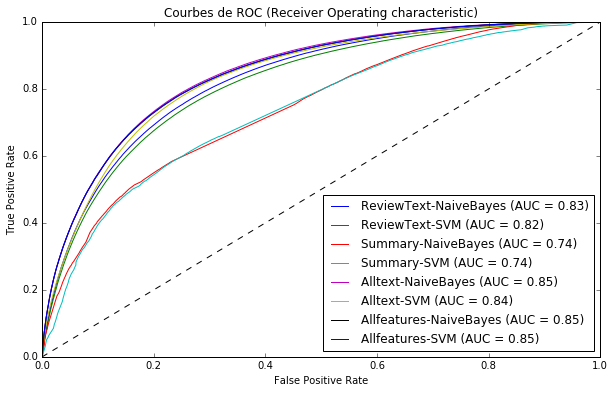

In [90]:
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10, 6)
from sklearn.metrics import roc_curve, auc
probas = [probas_bin_NaiveBayes_reviewText,probas_bin_SVM_reviewText,
         probas_bin_NaiveBayes_summary, probas_bin_SVM_summary,
         probas_bin_NaiveBayes_alltext, probas_bin_SVM_alltext,
         probas_bin_NaiveBayes_allfeatures, probas_bin_SVM_allfeatures]
labels=["ReviewText-NaiveBayes","ReviewText-SVM","Summary-NaiveBayes","Summary-SVM",
        "Alltext-NaiveBayes","Alltext-SVM","Allfeatures-NaiveBayes","Allfeatures-SVM"]
fpr= [None] * len(probas)
tpr=[None] * len(probas)
thresholds=[None] * len(probas)
roc_auc=[None] * len(probas)
for i in range(len(probas)):    
    fpr[i], tpr[i], thresholds[i] = sklearn.metrics.roc_curve(y_test_bin.ravel().astype(float), probas[i], pos_label=1.0)
    roc_auc[i]=auc(fpr[i],tpr[i])
    plt.plot(fpr[i], tpr[i], label=labels[i]+" (AUC = %0.2f)" % roc_auc[i])
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Courbes de ROC (Receiver Operating characteristic)')
plt.legend(loc="lower right")

In [88]:
np.mean(y_test_bin.ravel().astype(float))

0.59939245814603148

On voit que l'apport des features supplémentaires n'importe qu'un petit gain d'AUC au classifieur SVM. Les modèles Naive Bayes sont toujours bien supérieurs en termes d'AUC aux modèles SVM.

## Optimisation des hyper-paramètres pour la classification binaire

Nous allons nous concentrer ici sur l'optimisation des hyperparamètres de chacun des classifieurs sur l'intégralité des features.

### 1. Optimisation du classifieur Naive Bayes

In [71]:
from sklearn import grid_search
parameters_NB = {'alpha':list(np.linspace(0.001,10,50))}
clf1=grid_search.GridSearchCV(MultinomialNB(), parameters_NB)
clf1.fit(X_train_allfeatures, y_train_bin)

GridSearchCV(cv=None, error_score='raise',
       estimator=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'alpha': [0.001, 0.20506122448979594, 0.40912244897959188, 0.61318367346938785, 0.81724489795918376, 1.0213061224489797, 1.2253673469387756, 1.4294285714285715, 1.6334897959183674, 1.8375510204081633, 2.0416122448979594, 2.2456734693877554, 2.4497346938775513, 2.6537959183673472, 2.85785...6938775510213, 9.1837551020408164, 9.3878163265306132, 9.5918775510204082, 9.795938775510205, 10.0]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [72]:
best_parameters, score, _ = max(clf1.grid_scores_, key=lambda x: x[1])
for param_name in sorted(parameters_NB.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

alpha: 0.001


In [73]:
score

0.77645421320953856

In [79]:
predicted_bin_NaiveBayes_optim_allfeatures = clf1.predict(X_test_allfeatures)

### 2. Optimisation du classifieur SVM

In [74]:
parameters_SVM = {'alpha':list(np.linspace(0.000001,0.001,50)),
                  'loss':["modified_huber","log"],
                  'penalty': ["l2", "l1","elasticnet"],
                 }
clf2=grid_search.GridSearchCV(SGDClassifier(), parameters_SVM)
clf2.fit(X_train_allfeatures, y_train_bin)

GridSearchCV(cv=None, error_score='raise',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'alpha': [9.9999999999999995e-07, 2.1387755102040818e-05, 4.1775510204081632e-05, 6.2163265306122456e-05, 8.2551020408163267e-05, 0.00010293877551020408, 0.00012332653061224492, 0.00014371428571428573, 0.00016410204081632654, 0.00018448979591836735, 0.00020487755102040816, 0.000225265306...97961224489795926, 0.001], 'penalty': ['l2', 'l1', 'elasticnet'], 'loss': ['modified_huber', 'log']},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [75]:
best_parameters, score, _ = max(clf2.grid_scores_, key=lambda x: x[1])
for param_name in sorted(parameters_SVM.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

alpha: 6.2163265306122456e-05
loss: 'modified_huber'
penalty: 'l2'


In [76]:
predicted_bin_SVM_optim_allfeatures = clf2.predict(X_test_allfeatures)

### Comparaison de performance entre classifieurs optimisés et non optimisés

In [80]:
index_clf=["NaiveBayes-Basic","NaiveBayes-Optimized","SVM-Basic","SVM-Optimized"]
predicted_clf=[predicted_bin_NaiveBayes_allfeatures, predicted_bin_NaiveBayes_optim_allfeatures,
               predicted_bin_SVM_allfeatures, predicted_bin_SVM_optim_allfeatures]
def percent_round1(x):
    return(str((x*100).round(1))+"%")
Accuracy_clf=[percent_round1(np.mean(x==y_test_bin)) for x in predicted_clf]
Report_clf=[sklearn.metrics.precision_recall_fscore_support(y_test_bin, x) for x in predicted_clf]
Precision_clf=[percent_round1(x[0][1]) for x in Report_clf]
Recall_clf=[percent_round1(x[1][1]) for x in Report_clf]
f1score_clf=[percent_round1(x[2][1]) for x in Report_clf]

dic_clf = {'Accuracy' : pd.Series(Accuracy_clf, index=index_clf),
     'Precision' : pd.Series(Precision_clf, index=index_clf),
     'Recall' : pd.Series(Recall_clf, index=index_clf),
     'f1-score': pd.Series(f1score_clf, index=index_clf),
    }
df_clf=pd.DataFrame(dic_clf)
df_clf

,Accuracy,Precision,Recall,f1-score
NaiveBayes-Basic,77.7%,78.8%,85.7%,82.1%
NaiveBayes-Optimized,77.7%,78.8%,85.7%,82.1%
SVM-Basic,77.7%,78.8%,85.7%,82.1%
SVM-Optimized,80.5%,81.0%,88.2%,84.4%


On voit que l'optimisation est sensible pour le classifieur SVM, qui dépasse maintenant le classifieur Naive Bayes. Cependant, le temps de calcul a été beaucoup plus long pour SVM que pour Naive Bayes.

## Analyse de la performance en fonction du nombre de mots

In [ ]:
def createBins(x):
    if x["countWordsReview"] < 17:
        return(17)
    elif x["countWordsReview"] < 30:
        return(30)
    elif x["countWordsReview"] < 60:
        return(60)
    elif x["countWordsReview"] < 100:
        return(100)
    elif x["countWordsReview"] < 200:
        return(200)
    else:
        return(300)

In [ ]:
dfy = pd.DataFrame(y_test)

In [ ]:
dfy["predicted"] = predicted_bin_SVM_allfeatures

In [ ]:
dfy["reviewText"] = df_test["reviewText"]

In [ ]:
dfy["countWordsReview"] = dfy["reviewText"].apply(countWords)

In [ ]:
type(predicted_bin_SVM_allfeatures)

In [ ]:
predicted_bin_SVM_allfeatures

In [ ]:
y_test

In [ ]:
dfy = pd.DataFrame(y_test)
dfy["predicted"] = predicted_bin_SVM_allfeatures
dfy["reviewText"] = df_test["reviewText"]
dfy["countWordsReview"] = dfy["reviewText"].apply(countWords)
dfy["qualite"] = abs(predicted_bin_SVM_allfeatures - y_test)
dfy["bin"] = dfy.apply(createBins, axis = 1)
dfy.head()

In [ ]:
np.mean(dfy[dfy.bin==30]["qualite"])

In [ ]:
sum(abs(predicted_reviewText - y_test))

## Bits of useless code (so far)

In [ ]:
#an example with another function TfidfVectorizer using frequency instead of count
from sklearn.feature_extraction.text import TfidfVectorizer
corpus = ["This is very strange",
          "This is very nice"]
vectorizer = TfidfVectorizer(min_df=1)
X = vectorizer.fit_transform(corpus)
idf = vectorizer.idf_
print(dict(zip(vectorizer.get_feature_names(), idf)))

In [ ]:
# A possible approach that would require to construct pipelines
from sklearn.pipeline import FeatureUnion
from sklearn.feature_extraction import HashingVectorizer
hash_vect = HashingVectorizer()

In [ ]:
for i in range(0,5) :
        print(str(corpus_test_reviewText[i]) +"\n"+ "------ We predict "+ str(predicted_reviewText[i])+"\n")

Then: draw multi class ROC Curve using this example: http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

# Todo

- Analyse de la performance en fonction du nombre de mots
- Ajout d'un classifieur kNN
- Analyse des features les plus importantes dans chaque modèle